<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
 
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduce_image(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))

In [ ]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
#Retrieve original images
data_path = "drive/My Drive/ECE_542-Project_1/TrainingData"
# images, annotations = get_data(path)
img_names, images = loadImages(data_path)

# Get annotation csv file
# annotations = pd.read_csv(data_path)
annotations_path = os.path.join(data_path, 'Annotations.csv')
f_names, labels = loadAnnotations(annotations_path)

# Build dictionary with data
dataset = buildDataset(f_names, labels, img_names, images)


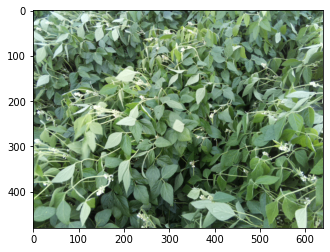

In [ ]:
#Display an image from dataset
sampleID = 19
plt.imshow(dataset[sampleID]['image'])
# print(dataset[sampleID])

In [ ]:
# Labels
# labels = np.asarray(annotations[['annotation']]).ravel() # Labels

# Spliting in images and pre_test
# split = int(0.8 * len(images))
# pre_test = images[split:]
# images = images[:split]
# pre_test_labels = labels[split:]
# labels = labels[:split]
print("Before Split")
countClasses(dataset)


# split = int(0.8 * len(dataset))
# pre_test = dataset[split:]
# images = dataset[:split]

print("After Split")
countClasses(images)

# # Counting images per class
# print("Class 0:", np.sum(labels == 0))
# print("Class 1:", np.sum(labels == 1))
# print("Class 2:", np.sum(labels == 2))
# print("Class 3:", np.sum(labels == 3))
# print("Class 4:", np.sum(labels == 4))

Before Split
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275
After Split
Class 0: 487
Class 1: 184
Class 2: 127
Class 3: 131
Class 4: 91
 Total : 1020


In [ ]:
# Data Augmentation Schemes
 
# Flipping image
def flip_image(images, labels, size = 480, flips = 3):
  images = reduce_image(images, size)
  flip_h = np.flip(images, axis = 1)
  flip_v = np.flip(images, axis = 2)
  flip_hv = np.flip(np.flip(images, axis = 1), axis = 2)
  if flips == 1:
     flip = np.vstack([images, flip_h])
     labels = np.asarray(list(labels) * 2).ravel()
  if flips == 2:
    flip = np.vstack([images, flip_h, flip_v])
    labels = np.asarray(list(labels) * 3).ravel()
  if flips == 3:
    flip = np.vstack([images, flip_h, flip_v, flip_hv])
    labels = np.asarray(list(labels) * 4).ravel()
  return flip, labels

# Gamma correction
def gamma_image(images, labels, gamma_values):
  images_gamma = [images]
  for gamma in gamma_values:
    #gamma_M = (np.power(images/255.0, 1/gamma) * 255).astype(int)
    images_gamma.append((np.power(images/255.0, 1/gamma) * 255).astype(int))#[labels == where_labels])
  images_gamma = np.vstack(images_gamma)
  #images_gamma = np.asarray(images_gamma)
  labels = np.asarray(list(labels) * (len(gamma_values) + 1)).ravel()
  return images_gamma, labels

# Divide image (NO IMPROVEMENT)
def slice_image(images, labels, num_slices):
  images_slice = []
  num_slices = 5
  sx = (np.arange(0, num_slices + 1) / num_slices * images.shape[1]).astype(int)
  sy = (np.arange(0, num_slices + 1) / num_slices * images.shape[2]).astype(int)
  for j in range(num_slices):
    for i in range(num_slices):
      images_slice.append(images[:, sx[i]:sx[i + 1], sy[j]:sy[j + 1], :])
  images_slice = np.vstack(images_slice)
  labels = np.asarray(list(labels) * num_slices * num_slices).ravel()
  return images_slice, labels

  # Separate images
  # for img in images
  #   reduced_images.append(rimg)
  #   reduced_images = np.array(reduced_images)
  # return img_class, label_class

In [ ]:
# Data augmentation

# Flipping images
images, labels = flip_image(images, labels, 80) # Image reduced size here!!!!
# Counting images per class
print("Class 0:", np.sum(labels == 0))
print("Class 1:", np.sum(labels == 1))
print("Class 2:", np.sum(labels == 2))
print("Class 3:", np.sum(labels == 3))
print("Class 4:", np.sum(labels == 4))

Class 0: 1948
Class 1: 736
Class 2: 508
Class 3: 524
Class 4: 364


In [ ]:
# Gamma correction
# images, labels = gamma_image(images, labels, [0.5, 1.5])
# images_g0, labels_g0 = gamma_image(images, labels, [0.5, 1.5]) # augmentation in class 0 , we dont need more data in this class
# images_g1, labels_g1 = gamma_image(images, labels, [0.5]) # augmentation in class 1
# images_g2, labels_g2 = gamma_image(images, labels, [0.5, 1.5]) # augmentation in class 2
# images_g3, labels_g3 = gamma_image(images, labels, [0.5, 1.5]) # augmentation in class 3
# images_g4, labels_g4 = gamma_image(images, labels, [0.5, 1, 1.5, 2]) # augmentation in class 4
# # Merging augmentation samples
# images = np.vstack([images, images_g1, images_g2, images_g3, images_g4])
# labels = np.hstack([labels, labels_g1, labels_g2, labels_g3, labels_g4])


In [ ]:
 # Counting images per class after augmentation
print("Class 0:", np.sum(labels == 0))
print("Class 1:", np.sum(labels == 1))
print("Class 2:", np.sum(labels == 2))
print("Class 3:", np.sum(labels == 3))
print("Class 4:", np.sum(labels == 4))

Class 0: 1948
Class 1: 736
Class 2: 508
Class 3: 524
Class 4: 364


In [ ]:
# Randomnize dataset
dataset_list = list(zip(images, labels))
np.random.shuffle(dataset_list)
images, labels = zip(*dataset_list)
images = np.asarray(images)
labels = np.asarray(labels)

In [ ]:
# Reducing Images
size = 80
#resized_images = reduce_image(images, size)
resized_images = images
print(resized_images.shape)
print(pre_test.shape)

(4080, 80, 80, 3)
(255, 480, 640, 3)


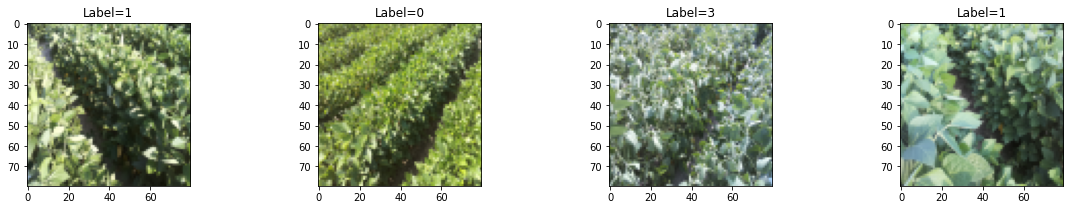

In [ ]:
# Plotting 16 random images
Num = 4
N = np.random.randint(0,len(resized_images), Num) 
# Plot
fig, axes = plt.subplots(1, Num, figsize=(20,3))
ax = axes.ravel()
for i in range(Num):
  ax[i].imshow(resized_images[N[i]])
  title = "Label=" + str(labels[N[i]])
  ax[i].title.set_text(title)

In [ ]:
#Keeping 20% for Validation
valid_set_pc = 0.4
split= int((len(resized_images))*(1-valid_set_pc))

#labels = annotations[['annotation']]
validX = resized_images[split:]
validY = labels[split:]
 
trainX = resized_images[:split]
trainY = labels[:split]

#Convert from integers to floats
resized_images = resized_images.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
 
# Normalize to range 0-1
resized_images = resized_images / 255.0
trainX = trainX / 255.0
validX = validX / 255.0
 
print(np.unique(labels), np.unique(trainY), np.unique(validY))
 
# One-hot encoding of outputs
labels = to_categorical(labels)
trainY = to_categorical(trainY)
validY = to_categorical(validY)
 
print(resized_images.shape)

[0 1 2 3 4] [0 1 2 3 4] [0 1 2 3 4]
(4080, 80, 80, 3)


In [ ]:
# Defining Base CNN Model
def define_base_model(height, width, rate):
    model = Sequential()
 
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
    model.add(Dropout(rate))
    model.add(MaxPooling2D((2, 2)))
 
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(Dropout(rate))
    model.add(MaxPooling2D((2, 2)))
 
    #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
    #model.add(Dropout(rate))
    #model.add(MaxPooling2D((2, 2)))
 
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate))    
    model.add(Dense(5, activation='softmax'))
 
    return model

In [ ]:
height = resized_images.shape[1]
width = resized_images.shape[2]
# Creating an instance
base_model = define_base_model(height, width, 0.3)
base_model.summary()
base_model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
adam_dropout_history = base_model.fit(trainX, trainY, epochs=35, validation_data=(validX, validY), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [ ]:
# GridSearch
# Define build function
def build_model(drop_val=0.2, l_rate=0.001):
  model = define_base_model(80, 80, drop_val)
  model.compile(optimizer=Adam(learning_rate = l_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
  # model = define_dropout_model(drop_val)
  # model.compile(optimizer=Adam(learning_rate = l_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  

# Define grid search parameters
params = {
    'drop_val' : [0.1, 0.2, 0.3, 0.4],
    'l_rate' : [0.1, 0.01, 0.001, 0.0005]
}

# Run gridsearch
model = KerasClassifier(build_fn = build_model, verbose = 0)
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=1, verbose=2)
grid_result = grid.fit(trainX, trainY)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] drop_val=0.1, l_rate=0.1 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... drop_val=0.1, l_rate=0.1, total=   1.2s
[CV] drop_val=0.1, l_rate=0.1 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ......................... drop_val=0.1, l_rate=0.1, total=   1.3s
[CV] drop_val=0.1, l_rate=0.1 ........................................
[CV] ......................... drop_val=0.1, l_rate=0.1, total=   1.1s
[CV] drop_val=0.1, l_rate=0.1 ........................................
[CV] ......................... drop_val=0.1, l_rate=0.1, total=   1.1s
[CV] drop_val=0.1, l_rate=0.1 ........................................
[CV] ......................... drop_val=0.1, l_rate=0.1, total=   1.1s
[CV] drop_val=0.1, l_rate=0.01 .......................................
[CV] ........................ drop_val=0.1, l_rate=0.01, total=   1.1s
[CV] drop_val=0.1, l_rate=0.01 .......................................
[CV] ........................ drop_val=0.1, l_rate=0.01, total=   1.1s
[CV] drop_val=0.1, l_rate=0.01 .......................................
[CV] ........................ drop_val=0.1, l_rate=0.01, total=   1.3s
[CV] drop_val=0.1, l_rate=0.01 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.5min finished


In [ ]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.5146913707256318
{'drop_val': 0.1, 'l_rate': 0.0005}


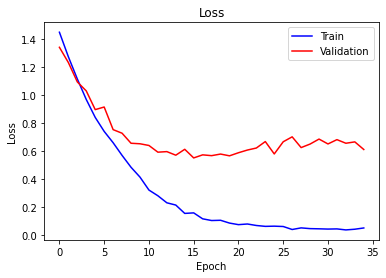

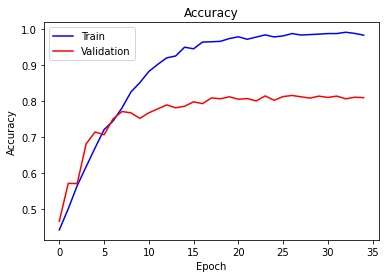

In [ ]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

# def plot_accuracy(history_tuple, lgd=[]):
#   plt.title('Training Accuracy')
#   for history in history_tuple:
#     plt.plot(history.history['accuracy'])
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(lgd)
#   plt.show()

#   plt.title('Validation Accuracy')
#   for history in history_tuple:
#     plt.plot(history.history['val_accuracy'])
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(lgd)
#   plt.show()
 
# Plotting results of training
plot_history(adam_dropout_history)

In [ ]:
# Counting images per class pre_test
print("Class 0:", np.sum(pre_test_labels == 0))
print("Class 1:", np.sum(pre_test_labels == 1))
print("Class 2:", np.sum(pre_test_labels == 2))
print("Class 3:", np.sum(pre_test_labels == 3))
print("Class 4:", np.sum(pre_test_labels == 4))

# pre_test accuracy
pre_test = reduce_image(pre_test, 80)
pre_results = base_model.predict_classes(pre_test)
print(np.sum(pre_results == pre_test_labels)/len(pre_test_labels))
# Counting images per class
print("Class 0:", np.sum(pre_results == 0))
print("Class 1:", np.sum(pre_results == 1))
print("Class 2:", np.sum(pre_results == 2))
print("Class 3:", np.sum(pre_results == 3))
print("Class 4:", np.sum(pre_results == 4))

Class 0: 1
Class 1: 145
Class 2: 3
Class 3: 0
Class 4: 106
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.08627450980392157
Class 0: 113
Class 1: 31
Class 2: 57
Class 3: 50
Class 4: 4


In [ ]:
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))

print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

['020031.jpg', '020244.jpg', '020446.jpg', '020597.jpg', '020693.jpg', '020720.jpg', '020783.jpg', '020795.jpg', '020810.jpg', '020833.jpg', '020835.jpg', '020848.jpg', '020861.jpg', '020877.jpg', '020881.jpg', '020963.jpg', '020980.jpg', '021039.jpg', '021048.jpg', '021095.jpg', '021104.jpg', '021220.jpg', '021267.jpg', '021366.jpg', '021423.jpg', '021455.jpg', '021457.jpg', '021621.jpg', '021659.jpg', '021729.jpg', '021763.jpg', '021773.jpg', '021818.jpg', '021819.jpg', '022010.jpg', '022021.jpg', '022090.jpg', '022127.jpg', '022145.jpg', '022158.jpg', '022202.jpg', '022231.jpg', '022377.jpg', '022385.jpg', '022432.jpg', '022438.jpg', '022497.jpg', '022551.jpg', '022554.jpg', '022628.jpg', '022629.jpg', '022642.jpg', '022757.jpg', '022800.jpg', '022826.jpg', '023041.jpg', '023112.jpg', '023195.jpg', '023229.jpg', '023278.jpg', '023291.jpg', '023304.jpg', '023330.jpg', '023369.jpg', '023370.jpg', '023381.jpg', '023458.jpg', '023468.jpg', '023474.jpg', '023476.jpg', '023508.jpg', '0235

reduce_test = reduce_image(test, 150)
print(reduce_test.shape)
 
results = base_model.predict_classes(reduce_test)
print(results)
print("Class 0:", np.sum(results == 0))
print("Class 1:", np.sum(results == 1))
print("Class 2:", np.sum(results == 2))
print("Class 3:", np.sum(results == 3))
print("Class 4:", np.sum(results == 4))

In [ ]:
# # Flip Test Images
# test_images, _ = flip_image(test, labels, 80) # Image reduced size here!!!!
# # Gamma Test Images
# test_images, _ = gamma_image(test_images, labels, [0.5, 1.5]) # Image reduced size here!!!!
# print(test_images.shape)

test_images = reduce_image(test, 80)
print(test_images.shape)

results = base_model.predict_classes(test_images)

print("Class 0:", np.sum(results == 0))
print("Class 1:", np.sum(results == 1))
print("Class 2:", np.sum(results == 2))
print("Class 3:", np.sum(results == 3))
print("Class 4:", np.sum(results == 4))

# Generate CSV file
data = {'file_name': file_name,'annotation': results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction.csv', index = False, header=True)
print(export_data)               


(200, 80, 80, 3)
Class 0: 101
Class 1: 21
Class 2: 43
Class 3: 35
Class 4: 0
      file_name  annotation
0    020031.jpg           0
1    020244.jpg           3
2    020446.jpg           3
3    020597.jpg           0
4    020693.jpg           0
..          ...         ...
195  029650.jpg           1
196  029787.jpg           1
197  029841.jpg           1
198  029866.jpg           0
199  029897.jpg           0

[200 rows x 2 columns]


IndexError: ignored

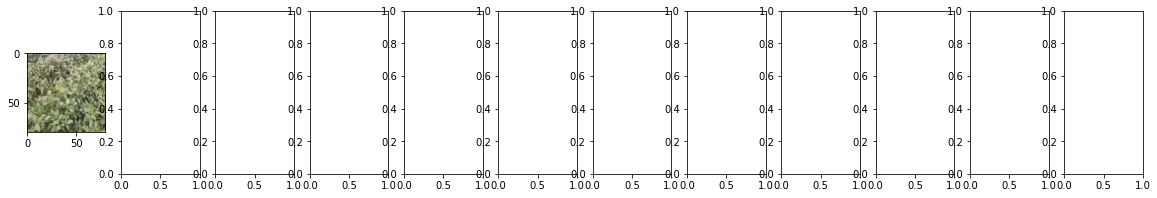

In [ ]:
# Plotting 16 random images
Num = 12
N = 0 
# Plot
fig, axes = plt.subplots(1, Num, figsize=(20,3))
ax = axes.ravel()
for i in range(Num):
  ax[i].imshow(test_images[N + i * len(test)])

In [ ]:
dd = results.reshape(len(test),12)
dd[0,:]

In [ ]:
# Defining CNN Model
def define_model(height, width):
    model = Sequential()
 
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
    model.add(MaxPooling2D((2, 2)))
 
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
 
    #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
    #model.add(Dropout(rate))
    #model.add(MaxPooling2D((2, 2)))
 
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
 
    return model

In [ ]:
#Base model predictions
base_results = base_model.predict_classes(validX)
#Compute F1 scores
trueY = np.argmax(validY, axis=1)

t = classification_report(trueY, base_results)
print(t)

#base_f1_score = f1_score(trueY, base_results, average=None)
#print(base_f1_score)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       759
           1       0.70      0.60      0.65       306
           2       0.72      0.75      0.74       203
           3       0.83      0.80      0.81       218
           4       0.96      0.89      0.93       146

    accuracy                           0.81      1632
   macro avg       0.81      0.79      0.80      1632
weighted avg       0.81      0.81      0.81      1632

